In [1]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from math import sqrt
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Create sql connection
cnx = sqlite3.connect('wfdata.sqlite')

In [3]:
# Tables
res = cnx.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print(name[0])

spatial_ref_sys
spatialite_history
sqlite_sequence
geometry_columns
spatial_ref_sys_aux
views_geometry_columns
virts_geometry_columns
geometry_columns_statistics
views_geometry_columns_statistics
virts_geometry_columns_statistics
geometry_columns_field_infos
views_geometry_columns_field_infos
virts_geometry_columns_field_infos
geometry_columns_time
geometry_columns_auth
views_geometry_columns_auth
virts_geometry_columns_auth
sql_statements_log
SpatialIndex
ElementaryGeometries
KNN
Fires
idx_Fires_Shape
idx_Fires_Shape_node
idx_Fires_Shape_rowid
idx_Fires_Shape_parent
NWCG_UnitIDActive_20170109


In [4]:
# Read selected features from the table Fire
df = pd.read_sql("SELECT \
                        FIRE_YEAR,DISCOVERY_DOY, STAT_CAUSE_CODE,\
                        STAT_CAUSE_DESCR,\
                        FIRE_SIZE, FIRE_SIZE_CLASS, LATITUDE,LONGITUDE,\
                        OWNER_DESCR, STATE, COUNTY, FIPS_NAME \
                        FROM Fires", cnx)

In [5]:
df.head()

,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,COUNTY,FIPS_NAME
0,2005,33,9.0,Miscellaneous,0.10,A,40.036944,-121.005833,USFS,CA,63,Plumas
1,2004,133,1.0,Lightning,0.25,A,38.933056,-120.404444,USFS,CA,61,Placer
2,2004,152,5.0,Debris Burning,0.10,A,38.984167,-120.735556,STATE OR PRIVATE,CA,17,El Dorado
3,2004,180,1.0,Lightning,0.10,A,38.559167,-119.913333,USFS,CA,3,Alpine
4,2004,180,1.0,Lightning,0.10,A,38.559167,-119.933056,USFS,CA,3,Alpine


In [6]:
df.shape

(1880465, 12)

# Initial Data Exploration

## Wildfire in US

In [7]:
# yearly number of fires
numFire_year = df['FIRE_YEAR'].value_counts().sort_index()

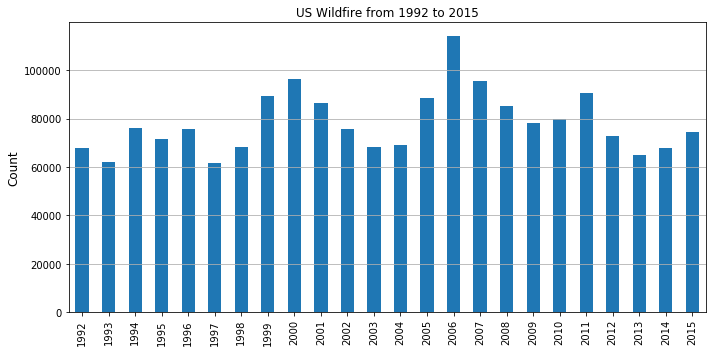

In [8]:
# plot yearly number of fires
fig, axs = plt.subplots(figsize=(10, 5))
numFire_year.plot(kind='bar', ax=axs)
axs.set_title('US Wildfire from 1992 to 2015')
axs.set_ylabel('Count', fontsize=12)
axs.yaxis.grid(True)
plt.tight_layout()

In [9]:
numFire_year.describe()

count        24.000000
mean      78352.708333
std       12759.039409
min       61450.000000
25%       68342.750000
50%       75615.000000
75%       87091.250000
max      114004.000000
Name: FIRE_YEAR, dtype: float64

## Wildfire in California

In [10]:
# data for wildfire in California
df_CA = df[df['STATE']=='CA']

In [11]:
df_CA.head()

,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,COUNTY,FIPS_NAME
0,2005,33,9.0,Miscellaneous,0.10,A,40.036944,-121.005833,USFS,CA,63,Plumas
1,2004,133,1.0,Lightning,0.25,A,38.933056,-120.404444,USFS,CA,61,Placer
2,2004,152,5.0,Debris Burning,0.10,A,38.984167,-120.735556,STATE OR PRIVATE,CA,17,El Dorado
3,2004,180,1.0,Lightning,0.10,A,38.559167,-119.913333,USFS,CA,3,Alpine
4,2004,180,1.0,Lightning,0.10,A,38.559167,-119.933056,USFS,CA,3,Alpine


In [12]:
numFire_year_CA = df_CA['FIRE_YEAR'].value_counts().sort_index()

In [13]:
numFire_year_CA.describe()

count       24.000000
mean      7897.916667
std       1162.025178
min       5776.000000
25%       7094.000000
50%       7828.500000
75%       8585.000000
max      10833.000000
Name: FIRE_YEAR, dtype: float64

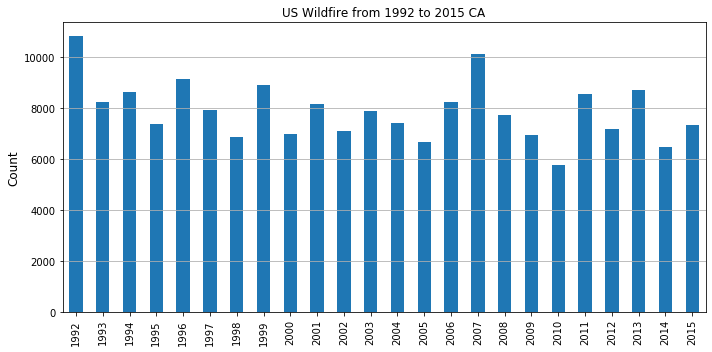

In [14]:
fig, axs = plt.subplots(figsize=(10, 5))
numFire_year_CA.plot(kind='bar')
axs.set_title('US Wildfire from 1992 to 2015 CA', fontsize=12)
axs.set_ylabel('Count', fontsize=12)
axs.yaxis.grid(True)
plt.tight_layout()

## Most and least fire prone counties in California

In [15]:
counties = df_CA['FIPS_NAME'].value_counts().sort_values(ascending=False)
print('number of counties in CA =', len(counties))

number of counties in CA = 59


In [16]:
counties.describe()

count      59.000000
mean      952.898305
std      1091.072151
min         1.000000
25%       246.500000
50%       591.000000
75%      1265.000000
max      6925.000000
Name: FIPS_NAME, dtype: float64

In [17]:
# ten most fire-prone counties
counties[:10]

Riverside         6925
Los Angeles       2703
El Dorado         2676
San Bernardino    2642
San Diego         2443
Fresno            2183
Siskiyou          2156
Shasta            2118
Butte             1768
Kern              1737
Name: FIPS_NAME, dtype: int64

In [18]:
# ten least fire-prone counties
counties[-10:]

San Benito       157
Solano           149
Ventura          132
Kings            119
Colusa           111
Glenn             94
Marin             69
Sutter            68
San Francisco     15
Douglas            1
Name: FIPS_NAME, dtype: int64

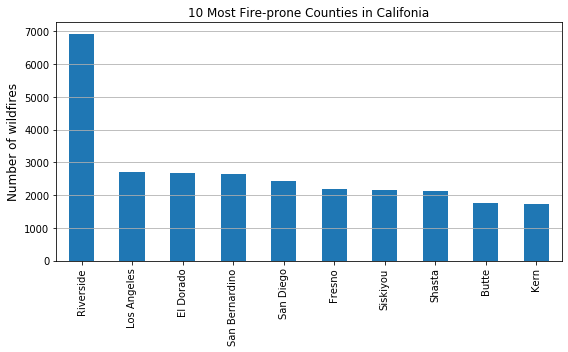

In [19]:
# plot ten most fire-prone counties
fig, axs = plt.subplots(figsize=(8, 5))
counties[:10].plot(kind='bar')
axs.set_title('10 Most Fire-prone Counties in Califonia', fontsize=12)
plt.ylabel('Number of wildfires', fontsize=12)
axs.yaxis.grid(True)
plt.tight_layout()

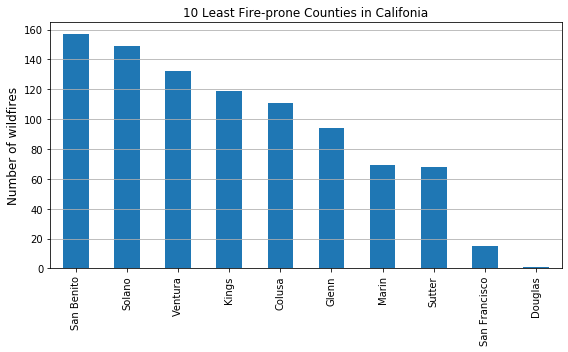

In [20]:
# plot ten least fire-prone counties
fig, axs = plt.subplots(figsize=(8, 5))
counties[-10:].plot(kind='bar')
axs.set_title('10 Least Fire-prone Counties in Califonia', fontsize=12)
axs.set_ylabel('Number of wildfires', fontsize=12)
axs.yaxis.grid(True)
plt.tight_layout()

## Fire size

In [21]:
fire_size = df_CA['FIRE_SIZE_CLASS'].value_counts().sort_index()

In [22]:
fire_size_catagories = {'A': '0.25', 'B': '0.26, 9.9', 'C': '10.0, 99.9',
                        'D': '100, 299', 'E': '300, 999', 'F': '1000,4999', 'G': '5000'}

In [23]:
fire_size

A    98309
B    76942
C     9825
D     2137
E     1187
F      756
G      394
Name: FIRE_SIZE_CLASS, dtype: int64

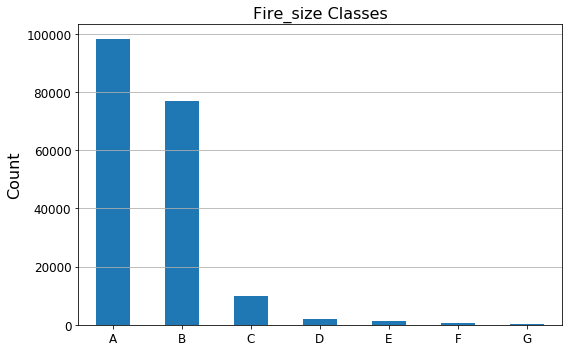

In [24]:
fig, axs = plt.subplots(figsize=(8, 5))
fire_size.plot(kind='bar')
axs.set_title('Fire_size Classes', fontsize=16)
axs.set_ylabel('Count',fontsize = 16)
axs.yaxis.grid(True)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)
plt.tight_layout()

## Stated cause of fire

In [25]:
stated_cause = df_CA['STAT_CAUSE_DESCR'].value_counts(
).sort_values(ascending=False)

In [26]:
stated_cause

Miscellaneous        51943
Equipment Use        39407
Lightning            27000
Arson                19635
Debris Burning       14318
Missing/Undefined    12605
Campfire              9516
Children              6930
Smoking               5936
Powerline             1198
Railroad               720
Fireworks              219
Structure              123
Name: STAT_CAUSE_DESCR, dtype: int64

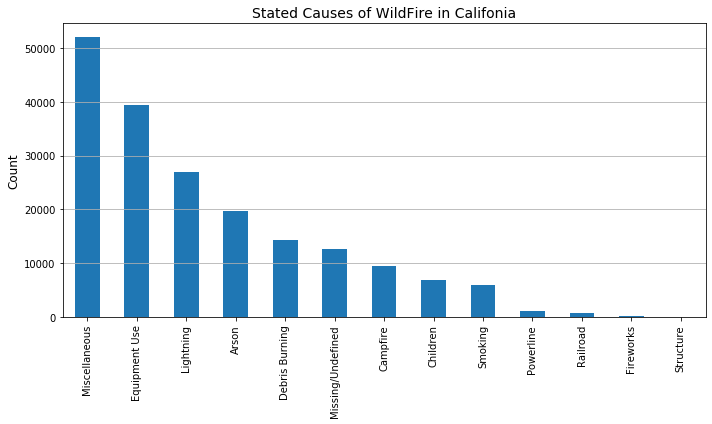

In [27]:
# plot stated cause of fire
fig, axs = plt.subplots(figsize=(10, 6))
stated_cause.plot(kind='bar')
axs.set_title('Stated Causes of WildFire in Califonia',fontsize=14)
axs.set_ylabel('Count',fontsize=12)
axs.yaxis.grid(True)
plt.tight_layout()

# Predict stated cause of fire

## Data Preparation

In [28]:
# check for missing values
df_CA.count()

FIRE_YEAR           189550
DISCOVERY_DOY       189550
STAT_CAUSE_CODE     189550
STAT_CAUSE_DESCR    189550
FIRE_SIZE           189550
FIRE_SIZE_CLASS     189550
LATITUDE            189550
LONGITUDE           189550
OWNER_DESCR         189550
STATE               189550
COUNTY               56221
FIPS_NAME            56221
dtype: int64

In [29]:
df_CA_1 = df_CA.drop(['COUNTY','FIPS_NAME'], axis=1)

In [30]:
df_CA_1.isnull().any()

FIRE_YEAR           False
DISCOVERY_DOY       False
STAT_CAUSE_CODE     False
STAT_CAUSE_DESCR    False
FIRE_SIZE           False
FIRE_SIZE_CLASS     False
LATITUDE            False
LONGITUDE           False
OWNER_DESCR         False
STATE               False
dtype: bool

In [31]:
# dictionary of stated cause name and code
stat_cause_dict = {'Miscellaneous': 9.0,
                   'Equipment Use': 2.0,
                   'Lightning': 1.0,
                   'Arson': 7.0,
                   'Debris Burning': 5.0,
                   'Missing/Undefined': 13.0,
                   'Campfire': 4.0,
                   'Children': 8.0,
                   'Smoking': 3.0,
                   'Railroad': 6.0,
                   'Powerline': 11.0,
                   'Fireworks': 10.0,
                   'Structure': 12.0}

In [32]:
df_CA_1.drop(['STAT_CAUSE_DESCR'],axis=1, inplace=True)

In [33]:
df_CA_1.head()

,FIRE_YEAR,DISCOVERY_DOY,STAT_CAUSE_CODE,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE
0,2005,33,9.0,0.10,A,40.036944,-121.005833,USFS,CA
1,2004,133,1.0,0.25,A,38.933056,-120.404444,USFS,CA
2,2004,152,5.0,0.10,A,38.984167,-120.735556,STATE OR PRIVATE,CA
3,2004,180,1.0,0.10,A,38.559167,-119.913333,USFS,CA
4,2004,180,1.0,0.10,A,38.559167,-119.933056,USFS,CA


In [34]:
df_CA_dummy = pd.concat(
    [pd.get_dummies(df_CA_1), 
     pd.get_dummies(df_CA_1['FIRE_YEAR'])], axis=1)\
    .drop(['FIRE_YEAR'], axis=1)

In [35]:
df_CA_dummy.head()

,DISCOVERY_DOY,STAT_CAUSE_CODE,FIRE_SIZE,LATITUDE,LONGITUDE,FIRE_SIZE_CLASS_A,FIRE_SIZE_CLASS_B,FIRE_SIZE_CLASS_C,FIRE_SIZE_CLASS_D,FIRE_SIZE_CLASS_E,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,33,9.0,0.10,40.036944,-121.005833,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,133,1.0,0.25,38.933056,-120.404444,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,152,5.0,0.10,38.984167,-120.735556,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,180,1.0,0.10,38.559167,-119.913333,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,180,1.0,0.10,38.559167,-119.933056,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
def train_test(stat_cause_code):
    """ Prepares data for one versus the rest binary classification.
        Arg: 
        stat_cause_code (stated cause of fire code)
        Return:
        X_train, y_train, X_test, y_test
        The classes of training dataset is balanced by upsampling.
    """

    # drop the label column
    X = df_CA_dummy.drop(['STAT_CAUSE_CODE'], axis=1)
    # prepare labels for one versus the rest binary classification
    y = ((df_CA_dummy['STAT_CAUSE_CODE'] == stat_cause_code) * 1)

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=42)

    # scale data
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train))
    X_test = pd.DataFrame(scaler.transform(X_test))

    # concatenate X_train and y_train
    y_train.reset_index(drop=True, inplace=True)  # reset index
    train = pd.concat([X_train, y_train], axis=1)
    train.rename(columns={'STAT_CAUSE_CODE': 'y'}, inplace=True)

    # separate the classes
    label_1 = train[train['y'] == 1]
    label_0 = train[train['y'] == 0]

    # upsample the label_1 to balance classes
    label_1_upsampled = resample(
        label_1, replace=True, n_samples=len(label_0), random_state=42)

    # combine the balanced train data and shuffle the data
    train_upsampled = pd.concat([label_1_upsampled, label_0], axis=0)\
        .sample(frac=1).reset_index(drop=True)

    # training data after balancing
    X_train = train_upsampled.drop('y', axis=1)
    y_train = train_upsampled['y']

    return X_train, y_train, X_test, y_test

In [37]:
stat_cause_dict

{'Miscellaneous': 9.0,
 'Equipment Use': 2.0,
 'Lightning': 1.0,
 'Arson': 7.0,
 'Debris Burning': 5.0,
 'Missing/Undefined': 13.0,
 'Campfire': 4.0,
 'Children': 8.0,
 'Smoking': 3.0,
 'Railroad': 6.0,
 'Powerline': 11.0,
 'Fireworks': 10.0,
 'Structure': 12.0}

## Random Forest Classifier

In [38]:
def random_forest(stat_cause_code):
     
    # get prepared data
    X_train, y_train, X_test, y_test = train_test(stat_cause_code)
    # train model
    rfc = RandomForestClassifier().fit(X_train, y_train)  
    # prediction
    rfc_pred = rfc.predict(X_test)

    y_score = rfc.predict_proba(X_test)[:, 1]

    AUC = roc_auc_score(y_test, y_score)
    accuracy = accuracy_score(y_test, rfc_pred)
    
    return AUC, accuracy

In [39]:
for i in range(5):
    print('stated cause of fire:', list(stat_cause_dict.keys())[i])
    AUC, accuracy = random_forest(list(stat_cause_dict.values())[i])
    print('AUC =', AUC)
    print('accuracy =', accuracy)
    print('\n')

stated cause of fire: Miscellaneous
AUC = 0.699080956686716
accuracy = 0.7170843225182449


stated cause of fire: Equipment Use
AUC = 0.756079354913535
accuracy = 0.775186846038864


stated cause of fire: Lightning
AUC = 0.9722927122770411
accuracy = 0.9473665699463641


stated cause of fire: Arson
AUC = 0.8021653745367412
accuracy = 0.9106831970456344


stated cause of fire: Debris Burning
AUC = 0.8365587798174849
accuracy = 0.9218851666227029


